# Emotion Classification from Speech

## 1. Setup and Imports

First, we'll import all the necessary libraries for our project. This includes libraries for data manipulation (`pandas`, `numpy`), audio processing (`librosa`), machine learning (`tensorflow`, `scikit-learn`), and plotting (`matplotlib`, `seaborn`).

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow messages

import warnings
warnings.filterwarnings('ignore')  # Suppress Python warnings

import tensorflow as tf
tf.get_logger().setLevel('ERROR')  # Suppress TF logs in notebook

# Rest of your imports
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import joblib
import random




E0000 00:00:1750913053.399938    5197 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750913053.466873    5197 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750913053.824192    5197 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750913053.824304    5197 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750913053.824321    5197 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750913053.824331    5197 computation_placer.cc:177] computation placer already registered. Please check linka

In [3]:

np.random.seed(42)
tf.random.set_seed(42)

DATA_PATH = '../data'
MODEL_PATH = '../models'
os.makedirs(MODEL_PATH, exist_ok=True)


In [4]:
emotion_map = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

def parse_filename(filename):
    parts = filename.replace('.wav', '').split('-')
    if len(parts) >= 7:
        emotion_code = parts[2]
        intensity = parts[3]
        statement = parts[4]
        repetition = parts[5]
        actor = parts[6]
        return {
            'filename': filename,
            'emotion_code': emotion_code,
            'emotion': emotion_map.get(emotion_code, 'unknown'),
            'intensity': intensity,
            'statement': statement,
            'repetition': repetition,
            'actor': actor
        }
    return None


In [5]:

def augment_audio(audio, sr):
    if random.random() < 0.3:
        noise = np.random.normal(0, 0.005, len(audio))
        audio = audio + noise
    if random.random() < 0.3:
        steps = float(np.random.uniform(-2, 2))
        audio = librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=steps)
    if random.random() < 0.3:
        rate = float(np.random.uniform(0.8, 1.2))
        audio = librosa.effects.time_stretch(y=audio, rate=rate)
        target_len = int(sr * 3)
        if len(audio) < target_len:
            audio = np.pad(audio, (0, target_len - len(audio)), 'constant')
        else:
            audio = audio[:target_len]
    return audio

def extract_features_from_audio(audio, sr):
    try:
        target_len = int(sr * 3)
        if len(audio) < target_len:
            audio = np.pad(audio, (0, target_len - len(audio)), 'constant')
        else:
            audio = audio[:target_len]
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
        mel = librosa.feature.melspectrogram(y=audio, sr=sr)
        contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
        tonnetz = librosa.feature.tonnetz(y=audio, sr=sr)
        centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(audio)
        rms = librosa.feature.rms(y=audio)

        features = np.concatenate([
            np.mean(mfcc.T, axis=0), np.std(mfcc.T, axis=0),
            np.mean(chroma.T, axis=0), np.std(chroma.T, axis=0),
            np.mean(mel.T, axis=0)[:20], np.std(mel.T, axis=0)[:20],
            np.mean(contrast.T, axis=0), np.std(contrast.T, axis=0),
            np.mean(tonnetz.T, axis=0), np.std(tonnetz.T, axis=0),
            np.mean(centroid.T, axis=0),
            np.mean(rolloff.T, axis=0),
            np.mean(zcr.T, axis=0),
            np.mean(rms.T, axis=0)
        ])
        return features
    except Exception as e:
        print(f"Error processing audio array: {e}")
        return None

def extract_features(file_path, max_length=3):
    try:
        audio, sr = librosa.load(file_path, sr=22050, duration=max_length)
        return extract_features_from_audio(audio, sr)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None




In [6]:
def create_improved_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(512, activation='relu', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def predict_emotion(audio_file_path):
    model = tf.keras.models.load_model(f'{MODEL_PATH}/final_emotion_classifier_model.h5')
    scaler = joblib.load(f'{MODEL_PATH}/final_scaler.pkl')
    label_encoder = joblib.load(f'{MODEL_PATH}/final_label_encoder.pkl')

    features = extract_features(audio_file_path)
    if features is None:
        return "Error: Could not extract features from audio file"

    features_scaled = scaler.transform(features.reshape(1, -1))
    prediction = model.predict(features_scaled)
    predicted_class = np.argmax(prediction[0])
    predicted_emotion = label_encoder.inverse_transform([predicted_class])[0]
    confidence = np.max(prediction[0])
    return {
        'emotion': predicted_emotion,
        'confidence': confidence,
        'probabilities': dict(zip(label_encoder.classes_, prediction[0]))
    }
        


In [7]:
audio_files = []
for actor_dir in os.listdir(DATA_PATH):
    if actor_dir.startswith('Actor_'):
        actor_path = os.path.join(DATA_PATH, actor_dir)
        if os.path.isdir(actor_path):
            for file in os.listdir(actor_path):
                if file.endswith('.wav'):
                    metadata = parse_filename(file)
                    if metadata:
                        metadata['filepath'] = os.path.join(actor_path, file)
                        audio_files.append(metadata)

df = pd.DataFrame(audio_files)
print(f"Total audio files found: {len(df)}")
print(df['emotion'].value_counts())

Total audio files found: 1440
emotion
happy        192
disgust      192
calm         192
fearful      192
angry        192
sad          192
surprised    192
neutral       96
Name: count, dtype: int64


In [8]:
features_list = []
valid_indices = []

print("Extracting features...")

for idx, row in tqdm(df.iterrows(), total=len(df)):
    features = extract_features(row['filepath'])
    if features is not None:
        features_list.append(features)
        valid_indices.append(idx)

        # Data augmentation: only for first 70%
        if idx < int(0.7 * len(df)):
            audio, sr = librosa.load(row['filepath'], sr=22050, duration=3)
            audio_aug = augment_audio(audio, sr)
            features_aug = extract_features_from_audio(audio_aug, sr)
            if features_aug is not None:
                features_list.append(features_aug)
                valid_indices.append(idx)

# Convert to dataframe and numpy array
df_filtered = df.iloc[valid_indices].reset_index(drop=True)
features_array = np.array(features_list)

# Print summary
print(f"\n Extracted features from {len(features_array)} samples.")
print(f"Filtered DataFrame shape: {df_filtered.shape}")
print(f"Feature array shape: {features_array.shape}")


Extracting features...


  0%|          | 0/1440 [00:00<?, ?it/s]

100%|██████████| 1440/1440 [21:12<00:00,  1.13it/s] 


 Extracted features from 2447 samples.
Filtered DataFrame shape: (2447, 8)
Feature array shape: (2447, 120)


In [9]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df_filtered['emotion'])

X_train, X_temp, y_train, y_temp = train_test_split(
    features_array, labels, test_size=0.3, random_state=42, stratify=labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


Epoch 1: val_accuracy improved from -inf to 0.35150, saving model to ../models/final_emotion_model.h5



Epoch 2: val_accuracy improved from 0.35150 to 0.41417, saving model to ../models/final_emotion_model.h5



Epoch 3: val_accuracy improved from 0.41417 to 0.42779, saving model to ../models/final_emotion_model.h5



Epoch 4: val_accuracy improved from 0.42779 to 0.47956, saving model to ../models/final_emotion_model.h5



Epoch 5: val_accuracy improved from 0.47956 to 0.49319, saving model to ../models/final_emotion_model.h5



Epoch 6: val_accuracy improved from 0.49319 to 0.52861, saving model to ../models/final_emotion_model.h5



Epoch 7: val_accuracy improved from 0.52861 to 0.54496, saving model to ../models/final_emotion_model.h5



Epoch 8: val_accuracy improved from 0.54496 to 0.57493, saving model to ../models/final_emotion_model.h5



Epoch 9: val_accuracy improved from 0.57493 to 0.58311, saving model to ../models/final_emotion_model.h5



Epoch 10: val_accuracy improved from 0.58311 to 0.58856, saving model to ../models/final_emotion_model.h5



Epoch 11: val_accuracy improved from 0.58856 to 0.60218, saving model to ../models/final_emotion_model.h5



Epoch 12: val_accuracy improved from 0.60218 to 0.63488, saving model to ../models/final_emotion_model.h5



Epoch 13: val_accuracy did not improve from 0.63488

Epoch 14: val_accuracy did not improve from 0.63488

Epoch 15: val_accuracy improved from 0.63488 to 0.66213, saving model to ../models/final_emotion_model.h5



Epoch 16: val_accuracy did not improve from 0.66213

Epoch 17: val_accuracy did not improve from 0.66213

Epoch 18: val_accuracy did not improve from 0.66213

Epoch 19: val_accuracy did not improve from 0.66213

Epoch 20: val_accuracy did not improve from 0.66213

Epoch 21: val_accuracy did not improve from 0.66213

Epoch 22: val_accuracy improved from 0.66213 to 0.68392, saving model to ../models/final_emotion_model.h5



Epoch 23: val_accuracy improved from 0.68392 to 0.68665, saving model to ../models/final_emotion_model.h5



Epoch 24: val_accuracy improved from 0.68665 to 0.68937, saving model to ../models/final_emotion_model.h5



Epoch 25: val_accuracy improved from 0.68937 to 0.70027, saving model to ../models/final_emotion_model.h5



Epoch 26: val_accuracy did not improve from 0.70027

Epoch 27: val_accuracy did not improve from 0.70027

Epoch 28: val_accuracy improved from 0.70027 to 0.72207, saving model to ../models/final_emotion_model.h5



Epoch 29: val_accuracy did not improve from 0.72207

Epoch 30: val_accuracy did not improve from 0.72207

Epoch 31: val_accuracy did not improve from 0.72207

Epoch 32: val_accuracy did not improve from 0.72207

Epoch 33: val_accuracy did not improve from 0.72207

Epoch 34: val_accuracy did not improve from 0.72207

Epoch 35: val_accuracy did not improve from 0.72207

Epoch 36: val_accuracy did not improve from 0.72207

Epoch 37: val_accuracy did not improve from 0.72207

Epoch 38: val_accuracy did not improve from 0.72207

Epoch 39: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 39: val_accuracy did not improve from 0.72207

Epoch 40: val_accuracy did not improve from 0.72207

Epoch 41: val_accuracy did not improve from 0.72207

Epoch 42: val_accuracy did not improve from 0.72207

Epoch 43: val_accuracy did not improve from 0.72207

Epoch 44: val_accuracy did not improve from 0.72207

Epoch 45: val_accuracy improved from 0.72207 to 0.73297, saving model to 


Epoch 46: val_accuracy did not improve from 0.73297

Epoch 47: val_accuracy did not improve from 0.73297

Epoch 48: val_accuracy did not improve from 0.73297

Epoch 49: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 49: val_accuracy did not improve from 0.73297

Epoch 50: val_accuracy did not improve from 0.73297

Epoch 51: val_accuracy did not improve from 0.73297

Epoch 52: val_accuracy did not improve from 0.73297

Epoch 53: val_accuracy did not improve from 0.73297

Epoch 54: val_accuracy did not improve from 0.73297

Epoch 55: val_accuracy did not improve from 0.73297

Epoch 56: val_accuracy did not improve from 0.73297

Epoch 57: val_accuracy did not improve from 0.73297

Epoch 58: val_accuracy did not improve from 0.73297

Epoch 59: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 59: val_accuracy did not improve from 0.73297

Epoch 60: val_accuracy did not improve from 0.73297

Epoch 61: val_accuracy did not improve from 0.73

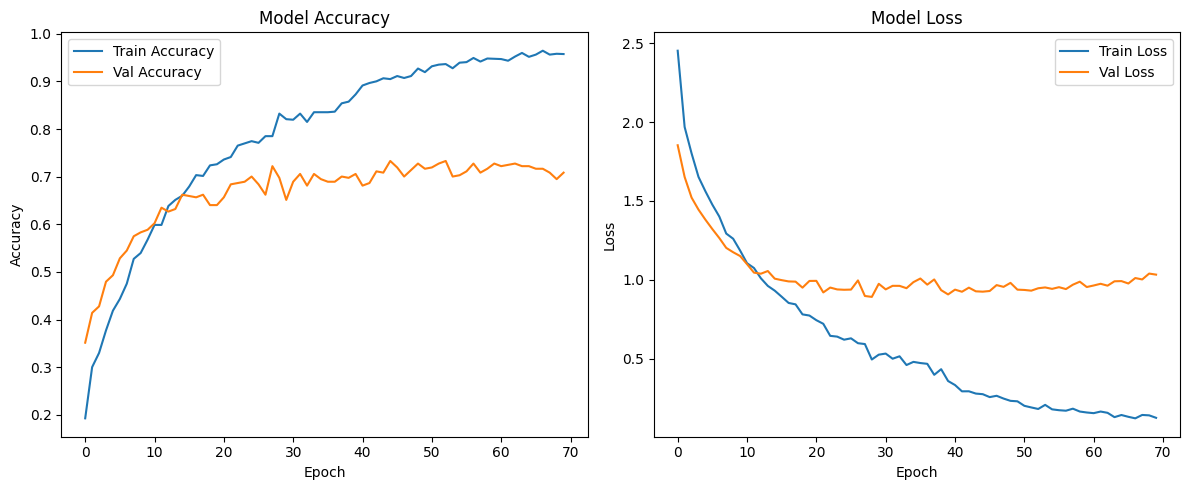

In [13]:
# Define input shape and number of output classes
input_shape = (X_train_scaled.shape[1],)
num_classes = len(label_encoder.classes_)

# Create the model
model = create_improved_model(input_shape, num_classes)

# Set training parameters
EPOCHS = 200
BATCH_SIZE = 16
PATIENCE = 25

# Callbacks for training
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=PATIENCE, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(f'{MODEL_PATH}/final_emotion_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Train the model (set verbose=1 for per-epoch summary or verbose=2 for compact output)
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=0
)

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [20]:
best_model = tf.keras.models.load_model(f'{MODEL_PATH}/final_emotion_model.h5')
test_loss, test_accuracy = best_model.evaluate(X_test_scaled, y_test, verbose=0)

y_pred = best_model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
print("Accuracy:", accuracy_score(y_test, y_pred_classes))
print("F1 Macro:", f1_score(y_test, y_pred_classes, average='macro'))
print("F1 Weighted:", f1_score(y_test, y_pred_classes, average='weighted'))

print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Accuracy: 0.6820652173913043
F1 Macro: 0.6762084246464333
F1 Weighted: 0.680712700787971
              precision    recall  f1-score   support

       angry       0.78      0.82      0.80        49
        calm       0.65      0.63      0.64        49
     disgust       0.71      0.73      0.72        49
     fearful       0.78      0.73      0.76        49
       happy       0.57      0.59      0.58        49
     neutral       0.55      0.68      0.61        25
         sad       0.62      0.49      0.55        49
   surprised       0.75      0.78      0.76        49

    accuracy                           0.68       368
   macro avg       0.67      0.68      0.68       368
weighted avg       0.68      0.68      0.68       368



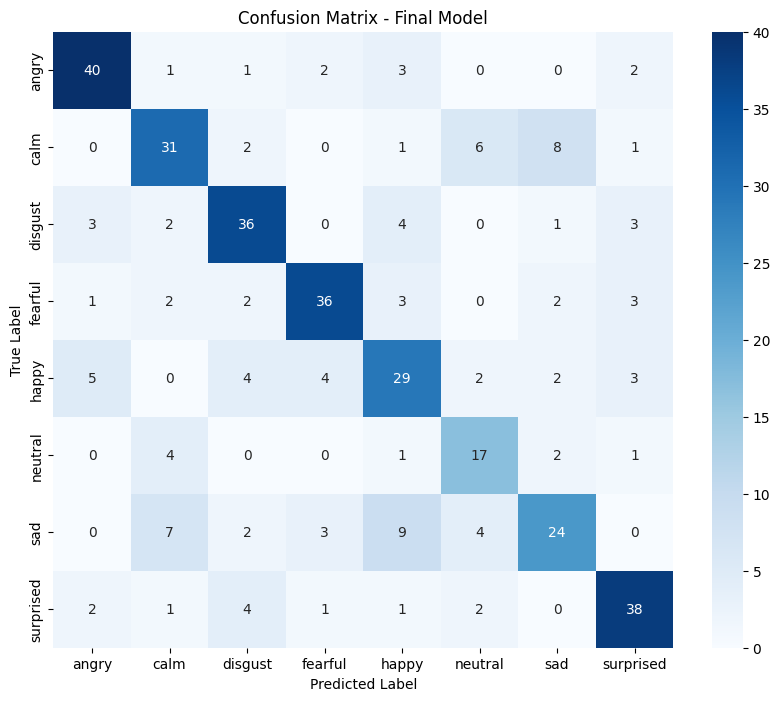

In [21]:
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Final Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [22]:
best_model.save(f'{MODEL_PATH}/final_emotion_classifier_model.h5')
joblib.dump(scaler, f'{MODEL_PATH}/final_scaler.pkl')
joblib.dump(label_encoder, f'{MODEL_PATH}/final_label_encoder.pkl')

['../models/final_label_encoder.pkl']

In [23]:
def predict_emotion(audio_path):
    model = tf.keras.models.load_model(f'{MODEL_PATH}/final_emotion_classifier_model.h5')
    scaler = joblib.load(f'{MODEL_PATH}/final_scaler.pkl')
    encoder = joblib.load(f'{MODEL_PATH}/final_label_encoder.pkl')
    
    features = extract_features(audio_path)
    if features is None:
        return "Invalid audio file"
    
    scaled = scaler.transform(features.reshape(1, -1))
    probs = model.predict(scaled)[0]
    pred = encoder.inverse_transform([np.argmax(probs)])[0]
    
    return pred, probs

sample_path = df_filtered.iloc[0]['filepath']
emotion, prob = predict_emotion(sample_path)
print(f"Predicted: {emotion}")
print(f"Confidence: {np.max(prob):.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
Predicted: happy
Confidence: 1.00
